# Model Comparisons

Compare with:

+ Arc
+ Act 1 & 2
+ Demo (Pulsed and SS)

// also adds prototype reactor designs (scylla and charybdis)

## 0.0 Bootup Notebook

In [1]:
# addprocs(8)

# @everywhere using Fussy

using Fussy
Main.IJulia.set_current_module(Fussy)

return

## 1.0 Set Defaults

In [2]:
cur_points = 121
min_temp = 0
max_temp = 40

cur_temps = collect(linspace(min_temp, max_temp, cur_points));


In [3]:
cur_decks = [
    :act_1, :act_2,
    :proteus, # pulsed
    :charybdis, # steady state
    :arc, 
    :demo_steady, :demo_pulsed
]

return

## 2.0 Define Make Function

In [4]:
function make_scans(cur_deck)
    println(cur_deck)
    
    tmp_scans = Dict()

    cur_symbol_pulsed = cur_deck
    cur_symbol_simple = Symbol("$(cur_deck)_simple")
    cur_symbol_steady = Symbol("$(cur_deck)_steady")

    tmp_scans[cur_symbol_pulsed] = Scan(cur_temps, deck=cur_deck, is_pulsed=true, is_consistent=false)
    tmp_scans[cur_symbol_simple] = Scan(cur_temps, deck=cur_deck, is_pulsed=false, is_consistent=false)
    tmp_scans[cur_symbol_steady] = Scan(cur_temps, deck=cur_deck, is_pulsed=false, is_consistent=true)
        
    tmp_scans
end

return

## 3.0 Get Data

In [5]:
cur_solutions = Dict()

for cur_deck in cur_decks
    tmp_symbol = Symbol("$(cur_deck)_solution")
    isdefined(Fussy, tmp_symbol) || continue
    cur_solutions[cur_deck] = getfield(Fussy, tmp_symbol)()
end

return

In [6]:
using FileIO
using JLD2

In [7]:
has_scans = isdefined(Fussy, :cur_scans)

cur_file = "../data/comparisons.jld2"

cur_scans = nothing
# try
    cur_scans = load(cur_file, "cur_scans")
# catch
#     cur_scans = Dict()
# end

Dict{Any,Any} with 21 entries:
  :charybdis_simple   => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :proteus            => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :arc_simple         => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :demo_steady        => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :charybdis          => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :proteus_steady     => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :proteus_simple     => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :act_1_steady       => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :act_2_steady       => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :demo_pulsed        => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :act_1              => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :charybdis_steady   => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0

In [8]:
# delete!(cur_scans, :demo_pulsed_steady)
# delete!(cur_scans, :demo_pulsed)
# delete!(cur_scans, :demo_pulsed_simple)

In [9]:
for cur_deck in cur_decks
    haskey(cur_scans, cur_deck) && continue
    tmp_scans = make_scans(cur_deck)
    merge!(cur_scans, tmp_scans)
    sleep(0.25)
end 

println("done.")

isempty(cur_scans) || save(cur_file, Dict("cur_scans" => cur_scans))

return

done.


In [24]:
using Plots
gr()

Plots.GRBackend()

In [11]:
cur_beta_wall_reactors = OrderedDict()
cur_beta_kink_reactors = OrderedDict()

for cur_suffix in ["", "_simple", "_steady"]
    for cur_deck in cur_decks
        print(".")
        sleep(0.1)

        is_consistent = cur_suffix == "_steady"
        is_pulsed = cur_suffix == ""

        tmp_reactor = Reactor(
            symbols(:T_bar), deck=cur_deck, constraint=:beta, 
            is_consistent=is_consistent, is_pulsed=is_pulsed
        )

        if tmp_reactor.is_consistent
            tmp_wall_reactor = hone(tmp_reactor, :wall)
            tmp_kink_reactor = hone(tmp_reactor, :kink)
        else
            tmp_wall_reactor = match(tmp_reactor, :wall)
            tmp_kink_reactor = match(tmp_reactor, :kink)
        end

        cur_symbol = Symbol("$cur_deck$cur_suffix")

        ( tmp_wall_reactor != nothing && tmp_wall_reactor.is_valid ) || ( tmp_wall_reactor = nothing )
        ( tmp_kink_reactor != nothing && tmp_kink_reactor.is_valid ) || ( tmp_kink_reactor = nothing )

        cur_beta_wall_reactors[cur_symbol] = tmp_wall_reactor
        cur_beta_kink_reactors[cur_symbol] = tmp_kink_reactor

        print("_")
        sleep(0.1)
    end
end


._._._._._._._._._._._._._._._._._._._._._

In [12]:
# for cur_suffix in ["", "_simple", "_steady"]
#     for cur_deck in cur_decks
        
#         cur_symbol = Symbol("$cur_deck$cur_suffix")
        
#         work_wall_reactor = cur_beta_wall_reactors[cur_symbol]
#         work_kink_reactor = cur_beta_kink_reactors[cur_symbol]

#         if work_wall_reactor != nothing
#             work_reactor_lists = [cur_scans[cur_symbol].beta_reactors, cur_scans[cur_symbol].wall_reactors]

#             for work_reactors in work_reactor_lists
#                 tmp_wall_reactor = deepcopy(work_wall_reactor)
#                 cur_branch_id_list = sort(unique(map(work_reactor -> work_reactor.branch_id, work_reactors)))

#                 min_branch_id = NaN
#                 min_error = Inf
#                 for cur_branch_id in cur_branch_id_list
#                     work_branch_reactors = filter(work_reactor -> work_reactor.branch_id == cur_branch_id, work_reactors)

#                     all(work_reactor -> work_reactor.is_valid, work_branch_reactors) && continue
#                     all(work_reactor -> !work_reactor.is_valid, work_branch_reactors) && continue

#                     filter!(work_reactor -> work_reactor.is_valid, work_branch_reactors)
                    
#                     cur_branch_t_list = map(work_reactor -> work_reactor.T_bar, work_branch_reactors)
#                     cur_branch_i_list = map(work_reactor -> work_reactor.I_P, work_branch_reactors)

#                     cur_error = polyfit(cur_branch_t_list, cur_branch_i_list, min(2, length(work_branch_reactors)-1))(tmp_wall_reactor.T_bar)
#                     cur_error /= tmp_wall_reactor.I_P
#                     cur_error -= 1.0
#                     cur_error ^= 2

#                     ( cur_error < min_error ) || continue
#                     min_error = cur_error
#                     min_branch_id = cur_branch_id
#                 end
                
#                 if isnan(min_branch_id)
#                     tmp_wall_reactor.branch_id = cur_branch_id_list[end] + 1
#                     push!(work_reactors, tmp_wall_reactor)
#                     continue
#                 end

#                 min_branch_reactors = filter(work_reactor -> work_reactor.is_valid && work_reactor.branch_id == min_branch_id, work_reactors)
                
#                 ( tmp_wall_reactor.T_bar == min_branch_reactors[1].T_bar ) && continue
#                 ( tmp_wall_reactor.T_bar == min_branch_reactors[end].T_bar ) && continue
                        
#                 tmp_wall_reactor.branch_id = min_branch_id
#                 push!(work_reactors, tmp_wall_reactor)
#             end
#         end
        
#         if work_kink_reactor != nothing
#             work_reactor_lists = [cur_scans[cur_symbol].beta_reactors, cur_scans[cur_symbol].kink_reactors]

#             for work_reactors in work_reactor_lists
#                 tmp_kink_reactor = deepcopy(work_kink_reactor)
#                 cur_branch_id_list = sort(unique(map(work_reactor -> work_reactor.branch_id, work_reactors)))

#                 min_branch_id = NaN
#                 min_error = Inf
#                 for cur_branch_id in cur_branch_id_list
#                     work_branch_reactors = filter(work_reactor -> work_reactor.branch_id == cur_branch_id, work_reactors)

#                     all(work_reactor -> work_reactor.is_valid, work_branch_reactors) && continue
#                     all(work_reactor -> !work_reactor.is_valid, work_branch_reactors) && continue

#                     filter!(work_reactor -> work_reactor.is_valid, work_branch_reactors)
                    
#                     cur_branch_t_list = map(work_reactor -> work_reactor.T_bar, work_branch_reactors)
#                     cur_branch_i_list = map(work_reactor -> work_reactor.I_P, work_branch_reactors)

#                     cur_error = polyfit(cur_branch_t_list, cur_branch_i_list, min(2, length(work_branch_reactors)-1))(tmp_kink_reactor.T_bar)
#                     cur_error /= tmp_kink_reactor.I_P
#                     cur_error -= 1.0
#                     cur_error ^= 2

#                     ( cur_error < min_error ) || continue
#                     min_error = cur_error
#                     min_branch_id = cur_branch_id
#                 end
                
#                 if isnan(min_branch_id)
#                     tmp_kink_reactor.branch_id = cur_branch_id_list[end] + 1
#                     push!(work_reactors, tmp_kink_reactor)
#                     continue
#                 end

#                 min_branch_reactors = filter(work_reactor -> work_reactor.is_valid && work_reactor.branch_id == min_branch_id, work_reactors)
                
#                 ( tmp_kink_reactor.T_bar == min_branch_reactors[1].T_bar ) && continue
#                 ( tmp_kink_reactor.T_bar == min_branch_reactors[end].T_bar ) && continue
            
#                 tmp_kink_reactor.branch_id = min_branch_id
#                 push!(work_reactors, tmp_kink_reactor)
#             end
#         end
#     end 
# end

## 4.0 Setup for Plots

In [13]:
cur_fields = [ 
    "T_bar", "n_bar", "I_P", "R_0", "B_0", "R_CS",
    "P_F", "f_IN", "f_BS", "f_CD", "W_M", "cost", "eta_CD", "P_ohmic",
    "norm_beta_N", "norm_q_95", "norm_P_E", "norm_P_W", "b", "c", "d"
]

sort!(cur_fields)

cur_xvars = deepcopy(cur_fields)
cur_yvars = deepcopy(cur_fields)

filter!(cur_var -> cur_var != "B_0", cur_xvars)
filter!(cur_var -> cur_var != "R_0", cur_yvars)

unshift!(cur_xvars, "B_0")
unshift!(cur_yvars, "R_0")

return

In [14]:
using Interact
using LaTeXStrings
using StringCases


## 5.0 Make Plot GUI

In [15]:
cur_scans

Dict{Any,Any} with 21 entries:
  :charybdis_simple   => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :proteus            => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :arc_simple         => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :demo_steady        => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :charybdis          => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :proteus_steady     => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :proteus_simple     => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :act_1_steady       => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :act_2_steady       => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :demo_pulsed        => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :act_1              => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0,…
  :charybdis_steady   => Fussy.Scan(AbstractFloat[0.0, 0.333333, 0.666667, 1.0

In [16]:
# function redistribute_branch_reactors!(cur_reactors::Vector{AbstractReactor})
#     cur_branch_id_list = map(cur_reactor -> cur_reactor.branch_id, cur_reactors)
#     min_branch_id = minimum(cur_branch_id_list)
#     max_branch_id = maximum(cur_branch_id_list)
    
#     @assert min_branch_id == 1
    
#     cur_branches = Vector{Vector{AbstractReactor}}(max_branch_id)
#     for cur_index in 1:max_branch_id
#         cur_branches[cur_index] = filter(
#             cur_reactor -> cur_reactor.branch_id == cur_index, 
#             cur_reactors
#         )
#     end
    
#     for (cur_branch_id, cur_branch_reactors) in enumerate(cur_branches)
#         cur_x_list = map(cur_reactor -> cur_reactor.T_bar, cur_branch_reactors)
#         cur_y_list = map(cur_reactor -> cur_reactor.I_P, cur_branch_reactors)
        
#         for (cur_index, (cur_x, cur_y)) in enumerate(zip(cur_x_list, cur_y_list))
#             best_branch_id = cur_branch_id
 
#             cur_y_guess = _make_scan_polyfit(cur_x_list, cur_y_list, cur_x)(cur_x)
#             cur_error = abs( cur_y - cur_y_guess )
            
#             for (cur_sub_branch_id, cur_sub_branch_reactors) in enumerate(cur_branches)
#                 ( cur_sub_branch_id == cur_branch_id ) && continue
#                 cur_sub_x_list = map(cur_reactor -> cur_reactor.T_bar, cur_sub_branch_reactors)
#                 cur_sub_y_list = map(cur_reactor -> cur_reactor.I_P, cur_sub_branch_reactors)
                
#                 in(cur_x, cur_sub_x_list) && continue
#                 cur_y_guess = _make_scan_polyfit(cur_sub_x_list, cur_sub_y_list, cur_x)(cur_x)
#                 tmp_error = abs( cur_y - cur_y_guess )
                
#                 ( tmp_error < cur_error ) || continue
                
#                 best_branch_id = cur_sub_branch_id
#                 cur_error = tmp_error
#             end
            
#             ( best_branch_id == cur_branch_id ) && continue
#             cur_branch_reactors[cur_index].branch_id = best_branch_id
#         end
#     end
# end

# redistribute_branch_reactors!(cur_scans[:demo_pulsed].kink_reactors)
# redistribute_branch_reactors!(cur_scans[:demo_pulsed].beta_reactors)
# redistribute_branch_reactors!(cur_scans[:act_1].beta_reactors)


In [17]:
# function collapse_singleton_reactors!(cur_reactors::Vector{AbstractReactor})
#     cur_branch_id_list = map(cur_reactor -> cur_reactor.branch_id, cur_reactors)
#     min_branch_id = minimum(cur_branch_id_list)
#     max_branch_id = maximum(cur_branch_id_list)
    
#     @assert min_branch_id == 1
    
#     cur_branches = Vector{Vector{AbstractReactor}}(max_branch_id)
#     for cur_index in 1:max_branch_id
#         cur_branches[cur_index] = filter(
#             cur_reactor -> (
#                 cur_reactor.is_valid &&
#                 cur_reactor.branch_id == cur_index
#             ), 
#             cur_reactors
#         )
#     end
    
#     for (cur_branch_id, cur_branch_reactors) in enumerate(cur_branches)
#         ( length(cur_branch_reactors) == 1 ) || continue
        
#         cur_branch_reactor = cur_branch_reactors[1]
    
#         (cur_x, cur_y) = cur_branch_reactor.T_bar, cur_branch_reactor.I_P

#         best_branch_id = cur_branch_id

#         cur_error = 1.0

#         for (cur_sub_branch_id, cur_sub_branch_reactors) in enumerate(cur_branches)
#             ( cur_sub_branch_id == cur_branch_id ) && continue
#             cur_sub_x_list = map(cur_reactor -> cur_reactor.T_bar, cur_sub_branch_reactors)
#             cur_sub_y_list = map(cur_reactor -> cur_reactor.I_P, cur_sub_branch_reactors)

#             in(cur_x, cur_sub_x_list) && continue
#             cur_y_guess = _make_scan_polyfit(cur_sub_x_list, cur_sub_y_list, cur_x)(cur_x)
#             tmp_error = abs( cur_y - cur_y_guess ) / cur_y

#                 println(tmp_error)
#             ( tmp_error < cur_error ) || continue

#             best_branch_id = cur_sub_branch_id
#             cur_error = tmp_error
#         end

#         ( best_branch_id == cur_branch_id ) && continue
#         cur_branch_reactor.branch_id = best_branch_id
#         println(best_branch_id)
#     end    
# end

# collapse_singleton_reactors!(cur_scans[:demo_pulsed].kink_reactors)


In [18]:
# function split_curvy_branches!(cur_reactors::Vector{AbstractReactor})
#     cur_branch_id_list = map(cur_reactor -> cur_reactor.branch_id, cur_reactors)
#     min_branch_id = minimum(cur_branch_id_list)
#     max_branch_id = maximum(cur_branch_id_list)
    
#     @assert min_branch_id == 1
    
#     cur_branches = Vector{Vector{AbstractReactor}}(max_branch_id)
#     for cur_index in 1:max_branch_id
#         cur_branches[cur_index] = filter(
#             cur_reactor -> cur_reactor.branch_id == cur_index, 
#             cur_reactors
#         )
#     end
    
#     for (cur_branch_id, cur_branch_reactors) in enumerate(cur_branches)
#         cur_branch_reactor = cur_branch_reactors[1]
        
#         cur_x_list = map(cur_reactor -> cur_reactor.T_bar, cur_branch_reactors)
#         cur_y_list = map(cur_reactor -> cur_reactor.I_P, cur_branch_reactors)

#         sort_lists!(cur_x_list, cur_y_list)
        
#         cur_dir_list = map(sign, diff(cur_y_list))
#         ( length(unique(cur_dir_list)) == 1 ) && continue

#         cur_direction_dict_list = Dict[]
        
#         push!(cur_direction_dict_list, 
#             Dict(
#                 :direction => cur_dir_list[1],
#                 :beg_index => 1,
#                 :end_index => length(cur_dir_list)
#             )
#         )
        
#         for (work_index, cur_direction) in enumerate(cur_dir_list[2:end])
#             cur_index = work_index + 1
#             ( cur_direction_dict_list[end][:direction] == cur_direction ) && continue
#             cur_direction_dict_list[end][:end_index] = cur_index - 1
            
#             push!(cur_direction_dict_list, 
#                 Dict(
#                     :direction => cur_direction,
#                     :beg_index => cur_index,
#                     :end_index => length(cur_dir_list)
#                 )
#             )
#         end 
        
#         cur_length_list = map(
#             cur_dict -> ( cur_dict[:end_index] - cur_dict[:beg_index] + 1 ),
#             cur_direction_dict_list
#         )
        
#         (min_value, min_index) = findmin(cur_length_list)
#         ( min_value == 1 ) || continue
        
#         cur_split_index = cur_direction_dict_list[min_index][:beg_index]
        
#         if length(cur_direction_dict_list) == 3 && min_index != 2
#             max_branch_id += 1
#             cur_branch_reactors[cur_split_index].branch_id = max_branch_id
#             continue
#         end
        
#         cur_split_index = cur_direction_dict_list[2][:beg_index]
        
#         mid_x = cur_x_list[cur_split_index]
#         mid_y = cur_y_list[cur_split_index]
        
#         bot_x = cur_x_list[cur_split_index-1]
#         top_x = cur_x_list[cur_split_index+1]
        
#         bot_y = _make_scan_polyfit(cur_x_list[1:cur_split_index-1], cur_y_list[1:cur_split_index-1], mid_x)(mid_x)
#         top_y = _make_scan_polyfit(cur_x_list[cur_split_index+1:end], cur_y_list[cur_split_index+1:end], mid_x)(mid_x)
        
#         bot_error = abs(mid_y - bot_y)/mid_y + abs(mid_x - bot_x)/mid_x
#         top_error = abs(mid_y - top_y)/mid_y + abs(mid_x - top_x)/mid_x
        
#         if bot_error < top_error
#             start_index = cur_split_index+1
#         else
#             start_index = cur_split_index
#         end
        
#         max_branch_id += 1
#         for cur_index in start_index:length(cur_branch_reactors)
#             cur_branch_reactors[cur_index].branch_id = max_branch_id
#         end
#     end    
# end

# # split_bad_branches!(cur_scans[:act_1].kink_reactors)
# split_curvy_branches!(cur_scans[:act_1].beta_reactors)
# # split_bad_branches!(cur_scans[:act_1].wall_reactors)


In [19]:
# function split_holey_branches!(cur_reactors::Vector{AbstractReactor})
#     cur_branch_id_list = map(cur_reactor -> cur_reactor.branch_id, cur_reactors)
#     min_branch_id = minimum(cur_branch_id_list)
#     max_branch_id = maximum(cur_branch_id_list)
    
#     @assert min_branch_id == 1
    
#     cur_branches = Vector{Vector{AbstractReactor}}(max_branch_id)
#     for cur_index in 1:max_branch_id
#         cur_branches[cur_index] = filter(
#             cur_reactor -> (
#                 cur_reactor.branch_id == cur_index &&
#                 cur_reactor.is_valid
#             ), 
#             cur_reactors
#         )
#     end
    
#     for (cur_branch_id, cur_branch_reactors) in enumerate(cur_branches)
#         ( length(cur_branch_reactors) < 3 ) && continue
        
#         cur_x_list = map(cur_reactor -> cur_reactor.T_bar, cur_branch_reactors)
#         cur_y_list = map(cur_reactor -> cur_reactor.I_P, cur_branch_reactors)

#         sort_lists!(cur_x_list, cur_y_list)

#         cur_diff = diff(cur_x_list)
#         cur_mode = mode(cur_diff)
        
#         (cur_max, cur_index) = findmax(cur_diff)
        
#         ( cur_max < 8 * cur_mode ) && continue
        
#         max_branch_id += 1
#         for cur_index in cur_index+1:length(cur_branch_reactors)
#             cur_branch_reactors[cur_index].branch_id = max_branch_id
#         end
#     end    
# end

# split_holey_branches!(cur_scans[:act_1].beta_reactors)
# split_holey_branches!(cur_scans[:act_1_steady].beta_reactors)


In [20]:
# function fix_branch_ids!(cur_reactors::Vector{AbstractReactor})
#     cur_branch_id_list = map(cur_reactor -> cur_reactor.branch_id, cur_reactors)
#     min_branch_id = minimum(cur_branch_id_list)
#     max_branch_id = maximum(cur_branch_id_list)
    
#     @assert min_branch_id == 1
    
# end

# fix_branch_ids!(cur_scans[:demo_pulsed].kink_reactors)

Interact.Options{:ToggleButtons,String}(17: "input-9" = B_0 String , "xvar", "B_0", "B_0", 1, Interact.OptionDict(DataStructures.OrderedDict("B_0"=>"B_0","I_P"=>"I_P","P_F"=>"P_F","P_ohmic"=>"P_ohmic","R_0"=>"R_0","R_CS"=>"R_CS","T_bar"=>"T_bar","W_M"=>"W_M","b"=>"b","c"=>"c"…), Dict("W_M"=>"W_M","I_P"=>"I_P","c"=>"c","B_0"=>"B_0","R_0"=>"R_0","b"=>"b","n_bar"=>"n_bar","eta_CD"=>"eta_CD","f_IN"=>"f_IN","norm_P_W"=>"norm_P_W"…)), Any[], Any[], true, "horizontal", true)

Interact.Options{:ToggleButtons,String}(19: "input-10" = R_0 String , "yvar", "R_0", "R_0", 1, Interact.OptionDict(DataStructures.OrderedDict("R_0"=>"R_0","B_0"=>"B_0","I_P"=>"I_P","P_F"=>"P_F","P_ohmic"=>"P_ohmic","R_CS"=>"R_CS","T_bar"=>"T_bar","W_M"=>"W_M","b"=>"b","c"=>"c"…), Dict("W_M"=>"W_M","I_P"=>"I_P","c"=>"c","R_0"=>"R_0","B_0"=>"B_0","b"=>"b","n_bar"=>"n_bar","eta_CD"=>"eta_CD","f_IN"=>"f_IN","norm_P_W"=>"norm_P_W"…)), Any[], Any[], true, "horizontal", true)

Interact.Options{:ToggleButtons,Symbol}(21: "input-11" = act_1 Symbol , "deck", :act_1, "act_1", 1, Interact.OptionDict(DataStructures.OrderedDict("act_1"=>:act_1,"act_2"=>:act_2,"proteus"=>:proteus,"charybdis"=>:charybdis,"arc"=>:arc,"demo_steady"=>:demo_steady,"demo_pulsed"=>:demo_pulsed), Dict(:act_1=>"act_1",:proteus=>"proteus",:demo_steady=>"demo_steady",:charybdis=>"charybdis",:act_2=>"act_2",:arc=>"arc",:demo_pulsed=>"demo_pulsed")), Any[], Any[], true, "horizontal", true)

Interact.Checkbox(23: "input-12" = false Bool , "showbad", false)

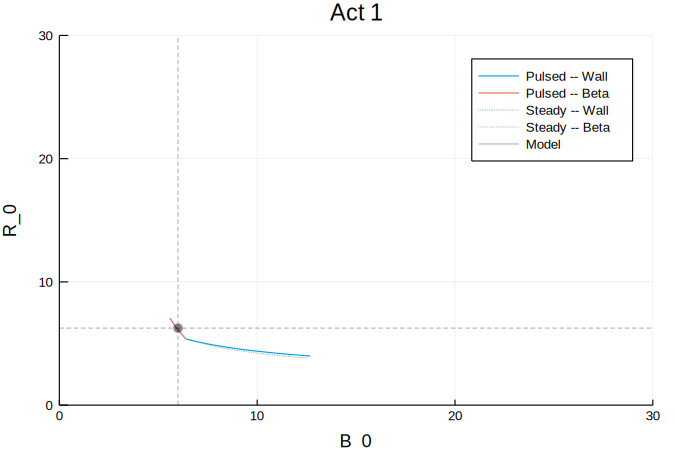

In [26]:
@manipulate for xvar in cur_xvars, yvar in cur_yvars, deck in (cur_decks), showbad=false
    tmp_plot = plot()
    
    cur_modes = Dict(
        "" => :solid
    )
    
    if startswith(string(deck), "demo_pulsed")
        cur_modes["_simple"] = :dot
    else
        cur_modes["_steady"] = :dot
    end
    
    max_x = 0
    max_y = 0
    
    for (cur_super_key, cur_super_value) in cur_modes
        
        ( cur_super_key != "_steady" && ( xvar == "eta_CD" || yvar == "eta_CD" ) ) && continue
        
        tmp_scan = cur_scans[Symbol("$(deck)$(cur_super_key)")]

        tmp_dict = Dict(
            "beta" => tmp_scan.beta_reactors,
            "kink" => tmp_scan.kink_reactors,
            "wall" => tmp_scan.wall_reactors
        )

        for (cur_key, cur_value) in tmp_dict
            if showbad
                cur_branch_id_list = map(tmp_reactor -> tmp_reactor.branch_id, cur_value)
                isempty(cur_branch_id_list) && continue
                max_branches = maximum(cur_branch_id_list)
                cur_branch_list = collect(1:max_branches)
            else
                tmp_value = filter(tmp_reactor -> tmp_reactor.is_valid, cur_value)
                filter!(tmp_reactor -> tmp_reactor.B_0 < 40, tmp_value)
                filter!(tmp_reactor -> tmp_reactor.R_0 < 40, tmp_value)
                isempty(tmp_value) && continue
                max_branches = maximum(map(tmp_reactor -> tmp_reactor.branch_id, tmp_value))
                cur_branch_list = collect(1:max_branches)
                
                skipped_branches = []
                for cur_branch in 1:max_branches
                    tmp_reactors = filter(tmp_value -> tmp_value.branch_id == cur_branch, cur_value)
                    filter!(tmp_reactor -> tmp_reactor.is_valid, tmp_reactors)
                    filter!(tmp_reactor -> tmp_reactor.B_0 < 40, tmp_reactors)
                    filter!(tmp_reactor -> tmp_reactor.R_0 < 40, tmp_reactors)
                    ( length(tmp_reactors) < 2 ) && push!(skipped_branches, cur_branch)
                end
                filter!(tmp_branch_id -> !in(tmp_branch_id, skipped_branches), cur_branch_list)
                max_branches = length(cur_branch_list)
            end
            
            used_branch_id = 0
            
            for cur_branch in cur_branch_list
                tmp_reactors = filter(tmp_value -> tmp_value.branch_id == cur_branch, cur_value)

                filter!(tmp_reactor -> tmp_reactor.B_0 < 40, tmp_reactors)
                filter!(tmp_reactor -> tmp_reactor.R_0 < 40, tmp_reactors)
                
                tmp_v = map(tmp_reactor -> tmp_reactor.is_valid, tmp_reactors)
                ( ( showbad ? length(tmp_reactors) : count(tmp_v) ) > 0 ) || continue

                tmp_x = map(tmp_reactor -> safe_get(tmp_reactor, xvar), tmp_reactors)
                tmp_y = map(tmp_reactor -> safe_get(tmp_reactor, yvar), tmp_reactors)

                tmp_t = map(tmp_reactor -> tmp_reactor.T_bar, tmp_reactors)
                tmp_i = map(tmp_reactor -> tmp_reactor.I_P, tmp_reactors)

                sort_lists!(tmp_t, tmp_v, tmp_x, tmp_y, tmp_i)
                
                if !showbad
                    tmp_x = tmp_x[tmp_v]
                    tmp_y = tmp_y[tmp_v]
                    tmp_t = tmp_t[tmp_v]
                    
                    if length(tmp_t) > 1
                        work_diff_list = diff(tmp_t)
                        work_min_diff = mode(work_diff_list) * 3
                        work_found_list = find(work_diff -> work_diff > work_min_diff, work_diff_list)

                        @assert length(work_found_list) < 2
                        if length(work_found_list) == 1
#                             println(work_diff_list)
#                             println(work_found_list)
#                             @assert work_found_list[1] == 1
#                             tmp_x = tmp_x[2:end]
#                             tmp_y = tmp_y[2:end]
                        end
                    end
                end
                                
                max_x = max(max_x, maximum(tmp_x))
                max_y = max(max_y, maximum(tmp_y))
                
                cur_prefix = cur_super_key == "" ? "Pulsed" : ( cur_super_key == "_steady" ) ? "Steady" : "Simple"
                cur_label = "$(cur_prefix) -- $(capitalize(cur_key))"
                
                used_branch_id += 1
                ( max_branches > 1 ) && ( cur_label *= " ($(romanize(used_branch_id)))" )
                
                if length(tmp_x) == 1
                    scatter!(tmp_x, tmp_y, label=cur_label, style=cur_super_value)
                else
                    plot!(tmp_x, tmp_y, label=cur_label, style=cur_super_value)
                end
            end
        end
        
    end
    
    min_x = 0
    min_y = 0
    
    max_x *= 1.4
    max_y *= 1.4
    
    ( xvar == "P_F" ) || 
        ( max_x = min(30, max_x) )
    
    ( yvar == "P_F" ) || 
        ( max_y = min(30, max_y) )
    
    ( xvar == "W_M" ) && ( max_x = 150 )
    ( yvar == "W_M" ) && ( max_y = 150 )
    
    ( xvar == "T_bar" ) && ( max_x = 40 )
    ( yvar == "T_bar" ) && ( max_y = 40 )
    
    ( xvar == "R_0" || xvar == "B_0" ) && ( max_x = 30 )
    ( yvar == "R_0" || yvar == "B_0" ) && ( max_y = 30 )
    
    if startswith(xvar, "norm_")
        max_x = 2.0 
    elseif startswith(xvar, "f_")
        max_x = 1.0
    elseif xvar == "cost"
        max_x = 0.1
    end
    
    if startswith(yvar, "norm_")
        max_y = 2.0 
    elseif startswith(yvar, "f_")
        max_y = 1.0
    elseif yvar == "cost"
        max_y = 0.1
    end
    
    if haskey(cur_solutions, deck)
        cur_soln = cur_solutions[deck]
        
        cur_soln_x = nothing
        cur_soln_y = nothing
        try
            cur_soln_x = getfield(cur_soln, Symbol(xvar))
        catch
        end
        
        try
            cur_soln_y = getfield(cur_soln, Symbol(yvar))
        catch
        end
        
        ( cur_soln_x != nothing ) &&
            plot!([cur_soln_x, cur_soln_x], [min_y, max_y], color=:black, opacity=0.3, label="", style=:dash)
        
        ( cur_soln_y != nothing ) &&
            plot!([min_x, max_x], [cur_soln_y, cur_soln_y], color=:black, opacity=0.3, label="", style=:dash)
        
        ( cur_soln_x != nothing && cur_soln_y != nothing ) &&
            scatter!([cur_soln_x], [cur_soln_y], color=:black, opacity=0.3, label="")
        
        plot!([0,0], [0,0], color=:black, opacity=0.3, label="Model")
    end
    
    xlims!(min_x, max_x)
    ylims!(min_y, max_y)
    
    xname = xvar
    yname = yvar

    xlabel!(xname)
    ylabel!(yname)
    
    xname = replace(xname, "eta_CD", "\\eta_{CD}")
    yname = replace(yname, "eta_CscD", "\\eta_{CD}")
    
    xname = replace(xname, "95", "{95}")
    yname = replace(yname, "95", "{95}")

    xname = replace(xname, "beta", "\\beta")
    yname = replace(yname, "beta", "\\beta")
    
    endswith(xname, "_bar") && ( xname = "\\overline $(split(xname, "_")[1])" )
    endswith(yname, "_bar") && ( yname = "\\overline $(split(yname, "_")[1])" )
    
    startswith(xname, "norm_") && ( xname = "\\left( $(replace(xname, "norm_", "")) \\right)_{norm}" )
    startswith(yname, "norm_") && ( yname = "\\left( $(replace(yname, "norm_", "")) \\right)_{norm}" )
    
    startswith(xname, "f_") && ( xname = join(map(cur_string -> "{$(cur_string)}", split(xname, "_")), "_") )
    startswith(yname, "f_") && ( yname = join(map(cur_string -> "{$(cur_string)}", split(yname, "_")), "_") )
    
#     xlabel!(latexstring(xname))
#     ylabel!(latexstring(yname))
    
    cur_title = join(map(capitalize, split(string(deck), "_")), " ")
    title!(cur_title)
    
#     savefig(tmp_plot, "$(cur_title)_$(xvar)_$(yvar)")
    
    plot!(dpi=450)
end

In [22]:
# @manipulate for xvar in cur_xvars, yvar in cur_yvars, deck in (cur_decks), showbad=[false,true]
#     plot()
    
#     cur_modes = Dict(
#         "" => :solid
#     )
    
#     if startswith(string(deck), "demo")
#         cur_modes["_simple"] = :dot
#     else
#         cur_modes["_steady"] = :dot
#     end
    
#     max_x = 0
#     max_y = 0
    
#     for (cur_super_key, cur_super_value) in cur_modes
        
#         ( cur_super_key != "_steady" && ( xvar == "eta_CD" || yvar == "eta_CD" ) ) && continue
        
#         tmp_scan = cur_scans[Symbol("$(deck)$(cur_super_key)")]

#         tmp_dict = Dict(
#             "beta" => tmp_scan.beta_reactors,
#             "kink" => tmp_scan.kink_reactors,
#             "wall" => tmp_scan.wall_reactors
#         )

#         for (cur_key, cur_value) in tmp_dict
#             max_branches = maximum(map(tmp_reactor -> tmp_reactor.branch_id, cur_value))

#             for cur_branch in 1:max_branches
#                 tmp_reactors = filter(tmp_value -> tmp_value.branch_id == cur_branch, cur_value)

#                 filter!(tmp_reactor -> tmp_reactor.B_0 < 40, tmp_reactors)
#                 filter!(tmp_reactor -> tmp_reactor.R_0 < 40, tmp_reactors)
                
#                 tmp_v = map(tmp_reactor -> tmp_reactor.is_valid, tmp_reactors)
#                 ( ( showbad ? length(tmp_reactors) : count(tmp_v) ) > 0 ) || continue

#                 tmp_x = map(tmp_reactor -> getfield(tmp_reactor, Symbol(xvar)), tmp_reactors)
#                 tmp_y = map(tmp_reactor -> getfield(tmp_reactor, Symbol(yvar)), tmp_reactors)

#                 tmp_t = map(tmp_reactor -> tmp_reactor.T_bar, tmp_reactors)
#                 tmp_i = map(tmp_reactor -> tmp_reactor.I_P, tmp_reactors)

#                 sort_lists!(tmp_t, tmp_v, tmp_x, tmp_y, tmp_i)

#                 if showbad
#                     first_index = 1
#                     last_index = length(tmp_reactors)
#                     valid_indices = collect(first_index:last_index)
#                 else
#                     first_index = minimum(find(tmp_v))
#                     last_index = maximum(find(tmp_v))
#                     valid_indices = find(tmp_v)
#                 end

# #                 ( first_index == 1 ) || ( first_index -= 1 )
# #                 ( last_index == length(tmp_reactors) ) || ( last_index += 1 )
# #                 println(tmp_t)
# #                 println(tmp_v)
                
# #                 tmp_x = tmp_x[first_index:last_index]
# #                 tmp_y = tmp_y[first_index:last_index]
                
                
                
#                 tmp_x = tmp_x[valid_indices]
#                 tmp_y = tmp_y[valid_indices]
                
#                 tmp_v = tmp_v[valid_indices]
                                
#                 max_x = max(max_x, maximum(tmp_x))
#                 max_y = max(max_y, maximum(tmp_y))

#                 cur_prefix = cur_super_key == "" ? "Pulsed" : ( cur_super_key == "_steady" ) ? "Steady" : "Simple"
#                 cur_label = "$(cur_prefix) -- $(capitalize(cur_key))"
#                 ( max_branches > 1 ) && ( cur_label *= " ($(romanize(cur_branch)))" )
                
#                 plot!(tmp_x, tmp_y, label=cur_label, style=cur_super_value)
#             end
#         end
        
#     end
    
#     min_x = 0
#     min_y = 0
    
#     max_x *= 1.4
#     max_y *= 1.4
    
#     ( xvar == "P_F" ) || 
#         ( max_x = min(30, max_x) )
    
#     ( yvar == "P_F" ) || 
#         ( max_y = min(30, max_y) )
    
#     ( xvar == "W_M" ) && ( max_x = 150 )
#     ( yvar == "W_M" ) && ( max_y = 150 )
    
#     ( xvar == "R_0" || xvar == "B_0" ) && ( max_x = 30 )
#     ( yvar == "R_0" || yvar == "B_0" ) && ( max_y = 30 )
    
#     if startswith(xvar, "norm_")
#         max_x = 2.0 
#     elseif startswith(xvar, "f_")
#         max_x = 1.0
#     elseif xvar == "cost"
#         max_x = 0.1
#     end
    
#     if startswith(yvar, "norm_")
#         max_y = 2.0 
#     elseif startswith(yvar, "f_")
#         max_y = 1.0
#     elseif yvar == "cost"
#         max_y = 0.1
#     end
    
#     if haskey(cur_solutions, deck)
#         cur_soln = cur_solutions[deck]
#         cur_soln_x = getfield(cur_soln, Symbol(xvar))
#         cur_soln_y = getfield(cur_soln, Symbol(yvar))
        
#         ( cur_soln_x != nothing ) &&
#             plot!([cur_soln_x, cur_soln_x], [min_y, max_y], color=:black, opacity=0.3, label="", style=:dash)
        
#         ( cur_soln_y != nothing ) &&
#             plot!([min_x, max_x], [cur_soln_y, cur_soln_y], color=:black, opacity=0.3, label="", style=:dash)
        
#         ( cur_soln_x != nothing && cur_soln_y != nothing ) &&
#             scatter!([cur_soln_x], [cur_soln_y], color=:black, opacity=0.3, label="")
        
#         plot!([0,0], [0,0], color=:black, opacity=0.3, label="Model")
#     end
    
#     xlims!(min_x, max_x)
#     ylims!(min_y, max_y)
    
#     xname = xvar
#     yname = yvar

#     xlabel!(xname)
#     ylabel!(yname)
    
#     xname = replace(xname, "eta_CD", "\\eta_{CD}")
#     yname = replace(yname, "eta_CD", "\\eta_{CD}")
    
#     xname = replace(xname, "95", "{95}")
#     yname = replace(yname, "95", "{95}")

#     xname = replace(xname, "beta", "\\beta")
#     yname = replace(yname, "beta", "\\beta")
    
#     endswith(xname, "_bar") && ( xname = "\\overline $(split(xname, "_")[1])" )
#     endswith(yname, "_bar") && ( yname = "\\overline $(split(yname, "_")[1])" )
    
#     startswith(xname, "norm_") && ( xname = "\\left( $(replace(xname, "norm_", "")) \\right)_{norm}" )
#     startswith(yname, "norm_") && ( yname = "\\left( $(replace(yname, "norm_", "")) \\right)_{norm}" )
    
#     startswith(xname, "f_") && ( xname = join(map(cur_string -> "{$(cur_string)}", split(xname, "_")), "_") )
#     startswith(yname, "f_") && ( yname = join(map(cur_string -> "{$(cur_string)}", split(yname, "_")), "_") )
    
# #     xlabel!(latexstring(xname))
# #     ylabel!(latexstring(yname))
    
#     cur_title = join(map(capitalize, split(string(deck), "_")), " ")
#     title!(cur_title)
    
#     plot!()
# end

In [23]:
cur_symbols = [:R_0, :B_0, :n_bar, :T_bar, :I_P, :P_F, :eta_CD, :f_BS, :H, :Q, :epsilon]

for cur_deck in cur_decks
    haskey(cur_solutions, cur_deck) || continue
    
    println()
    println(cur_deck, " solution")
    println()
    
    tmp_solution = cur_solutions[cur_deck]
    
    for cur_symbol in cur_symbols
        println(cur_symbol, " - ", getfield(tmp_solution, cur_symbol))
    end
    
    tmp_scan = cur_scans[cur_deck]
    tmp_reactor_list = []
    
    append!(tmp_reactor_list, tmp_scan.beta_reactors)
    append!(tmp_reactor_list, tmp_scan.kink_reactors)
    append!(tmp_reactor_list, tmp_scan.wall_reactors)

    closest_reactor = nothing
    min_error = Inf
    
    for tmp_reactor in tmp_reactor_list
        tmp_error = 0.0
#         tmp_error += abs( tmp_reactor.T_bar - tmp_solution.T_bar )/tmp_solution.T_bar 
#         tmp_error += abs( tmp_reactor.I_P - tmp_solution.I_P )/tmp_solution.I_P
        tmp_error += abs( tmp_reactor.R_0 - tmp_solution.R_0 )
        tmp_error += abs( tmp_reactor.B_0 - tmp_solution.B_0 )
        
        ( tmp_error < min_error ) || continue
        min_error = tmp_error
        
        closest_reactor = tmp_reactor
    end
    
    println()
    println(cur_deck, " found")
    println()
    
    for cur_symbol in cur_symbols
        println(cur_symbol, " - ", round(getfield(closest_reactor, cur_symbol),2))
    end
    
end


act_1 solution

R_0 - 6.25
B_0 - 6.0
n_bar - 1.3
T_bar - 20.6
I_P - 10.95
P_F - 1813
eta_CD - 0.188
f_BS - 0.91
H - 1.65
Q - 42.5
epsilon - 0.25

act_1 found

R_0 - 6.11
B_0 - 6.0
n_bar - 1.32
T_bar - 17.0
I_P - 10.66
P_F - 1834.28
eta_CD - 0.19
f_BS - 0.91
H - 1.65
Q - 42.5
epsilon - 0.25

act_2 solution

R_0 - 9.75
B_0 - 8.75
n_bar - 0.86
T_bar - 17.8
I_P - 13.98
P_F - 2637
eta_CD - 0.256
f_BS - 0.77
H - 1.22
Q - 25.0
epsilon - 0.25

act_2 found

R_0 - 9.78
B_0 - 9.09
n_bar - 0.95
T_bar - 19.33
I_P - 15.83
P_F - 4535.21
eta_CD - 0.26
f_BS - 0.69
H - 1.22
Q - 25.0
epsilon - 0.25

arc solution

R_0 - 3.3
B_0 - 9.2
n_bar - 1.3
T_bar - 14.0
I_P - 7.8
P_F - 525
eta_CD - 0.321
f_BS - 0.63
H - 1.8
Q - 13.6
epsilon - 0.3333

arc found

R_0 - 3.4
B_0 - 9.39
n_bar - 1.28
T_bar - 16.67
I_P - 8.75
P_F - 713.9
eta_CD - 0.32
f_BS - 0.56
H - 1.8
Q - 13.6
epsilon - 0.33

demo_steady solution

R_0 - 7.5
B_0 - 5.627
n_bar - 0.8746
T_bar - 18.067
I_P - 21.627
P_F - 3255
eta_CD - 0.4152
f_BS - 0.611
H 